In [28]:
import numpy as np
import gym 
import tensorflow as tf
import tf_slim as slim
from collections import deque,Counter 
import random 
from datetime import datetime 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display


In [2]:
color=np.array([210,164,74]).mean()

def preprocess_observation(observation):
    #crop
    image=observation[1:176:2,::2]
    #convert the image to grayscale
    image=image.mean(axis=2)
    #to increase the image contrast
    image[image==color]=0
    image=(image-128)/127
    
    return image.reshape(88,80,1)

In [3]:
environment=gym.make("MsPacman-v0")
n_outputs=environment.action_space.n
print('No of possible moves in the Pacman game is {}'.format(n_outputs))
print("Those moves are:")
moves_meaning=environment.env.get_action_meanings()
i=1
for move in moves_meaning:
    print("\t{0}:{1}".format(i,move))
    i+=1

No of possible moves in the Pacman game is 9
Those moves are:
	1:NOOP
	2:UP
	3:RIGHT
	4:LEFT
	5:DOWN
	6:UPRIGHT
	7:UPLEFT
	8:DOWNRIGHT
	9:DOWNLEFT


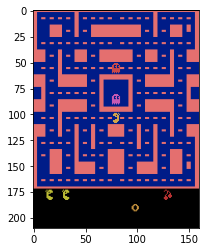

In [4]:
observation=environment.reset()
for j in range(22):
    if j>20:
        plt.imshow(observation)
        plt.show()
        
    observation,_, _, _=environment.step(1)
    

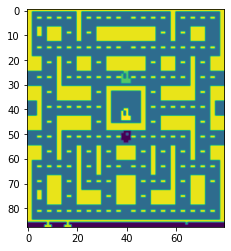

In [5]:
observation_preporcessed=preprocess_observation(observation).reshape(88,80)
plt.imshow(observation_preporcessed)
plt.show()

In [6]:
def q_network(X,name_scope):
    initializer = tf.keras.initializers.VarianceScaling(scale=2.0)
    
    with tf.compat.v1.variable_scope(name_scope) as scope:
        layer_1=slim.conv2d(X,num_outputs=64,kernel_size=(8,8),stride=4,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2=slim.conv2d(layer_1,num_outputs=64,kernel_size=(4,4),stride=2,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3=slim.conv2d(layer_2,num_outputs=64,kernel_size=(3,3),stride=1,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        flaten=slim.flatten(layer_3)
        fully_connected=slim.fully_connected(flaten,num_outputs=128,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fully_connected',fully_connected)
        output=slim.fully_connected(fully_connected,num_outputs=n_outputs,activation_fn=None,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        
        vars={v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
        
        return vars,output

In [7]:
epsilon=0.5
epsilon_max=1.0
epsilon_min=0.05
epsilon_decay_steps=500000

def epsilon_greedy(action,step):
    p=np.random.random(1).squeeze()
    epsilon=max(epsilon_min,epsilon_max-(epsilon_max-epsilon_min)*step/epsilon_decay_steps)
    if np.random.rand()<epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [8]:
buffer_len=20000
exp_buffer=deque(maxlen=buffer_len)

def sample_memories(batch_size):
    parm_batch=np.random.permutation(len(exp_buffer))[:batch_size]
    mem=np.array(exp_buffer)[parm_batch]
    return mem[:,0],mem[:,1],mem[:,2],mem[:,3],mem[:,4]

In [9]:
num_episodes=800
batch_size=48
input_shape=(None,88,80,1)
learning_rate=0.001
x_shape=(None,88,80,1)
discount_factor=0.97

global_step=0
copy_steps=100
steps_train=4
start_steps=2000

In [10]:
log_dir="logs"
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
X = tf.compat.v1.placeholder(tf.float32, shape=x_shape)
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [11]:
mainQ,mainQ_outputs=q_network(X,'mainQ')
targetQ,targetQ_outputs=q_network(X,'targetQ')

In [12]:
x_action=tf.compat.v1.placeholder(tf.int32,shape=(None,))
q_action=tf.reduce_sum(input_tensor=targetQ_outputs*tf.one_hot(x_action,n_outputs),axis=1,keepdims=True)

In [13]:
copy_op=[tf.compat.v1.assign(main_name,targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main=tf.group(*copy_op)

In [14]:
y=tf.compat.v1.placeholder(tf.float32,shape=(None,1))

loss=tf.reduce_mean(input_tensor=tf.square(y-q_action))
optimizer=tf.compat.v1.train.AdadeltaOptimizer(learning_rate)
traning_optimizer=optimizer.minimize(loss)

init=tf.compat.v1.global_variables_initializer()
loss_summary=tf.compat.v1.summary.scalar('LOSS',loss)
merge_summary=tf.compat.v1.summary.merge_all()
file_writer=tf.compat.v1.summary.FileWriter(log_dir,tf.compat.v1.get_default_graph())

In [40]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    history=[]
    for i in range(num_episodes):
        done=False
        observation=environment.reset()
        epoch=0
        episodic_reward=0
        actions_counter=Counter()
        episodic_loss=[]
        
        while not done:
            
            observation=preprocess_observation(observation)
            actions=mainQ_outputs.eval(feed_dict={X:[observation],in_training_mode:False})
            
            action=np.argmax(actions,axis=-1)
            actions_counter[str(action)]+=1
            
            action=epsilon_greedy(action,global_step)
            next_observation, reward, done, _= environment.step(int(action))
            exp_buffer.append([observation,action,preprocess_observation(next_observation),reward,done])
            
            if global_step%steps_train==0 and global_step>start_steps:
                o_obs,o_act,o_next_obs,o_rew,o_done=sample_memories(batch_size)
                
                o_obs=[x for x in o_obs]
                o_next_obs=[x for x in o_next_obs]
                
                next_act=mainQ_outputs.eval(feed_dict={X:o_next_obs,in_training_mode:False})
                
                y_batch=o_rew+discount_factor*np.max(next_act,axis=-1)*(1-o_done)
                
                merg_summary=merge_summary.eval(feed_dict={X:o_obs,y:np.expand_dims(y_batch,axis=-1),x_action:o_act,in_training_mode:False})
                file_writer.add_summary(merg_summary,global_step)
                
                train_loss,_=sess.run([loss,traning_optimizer],feed_dict={X:o_obs,y:np.expand_dims(y_batch,axis=-1),x_action:o_act,in_training_mode:False})
                episodic_loss.append(train_loss)
                
            if(global_step+1)%copy_steps==0 and global_step>start_steps:
                copy_target_to_main.run()
            
            observation=next_observation
            epoch+=1
            global_step+=1
            episodic_reward+=reward
        
        history.append(episodic_reward)
        print("Epochs per episode:{} Episode Reward:{} Episode Number:{}".format(epoch,episodic_reward,len(history)))

Epochs per episode:673 Episode Reward:210.0 Episode Number:1
Epochs per episode:899 Episode Reward:330.0 Episode Number:2
Epochs per episode:837 Episode Reward:330.0 Episode Number:3
Epochs per episode:652 Episode Reward:130.0 Episode Number:4
Epochs per episode:582 Episode Reward:210.0 Episode Number:5
Epochs per episode:609 Episode Reward:190.0 Episode Number:6
Epochs per episode:633 Episode Reward:250.0 Episode Number:7
Epochs per episode:701 Episode Reward:270.0 Episode Number:8
Epochs per episode:631 Episode Reward:200.0 Episode Number:9
Epochs per episode:673 Episode Reward:170.0 Episode Number:10
Epochs per episode:707 Episode Reward:220.0 Episode Number:11
Epochs per episode:634 Episode Reward:170.0 Episode Number:12
Epochs per episode:550 Episode Reward:110.0 Episode Number:13
Epochs per episode:670 Episode Reward:180.0 Episode Number:14
Epochs per episode:609 Episode Reward:200.0 Episode Number:15
Epochs per episode:600 Episode Reward:250.0 Episode Number:16
Epochs per episod

KeyboardInterrupt: 

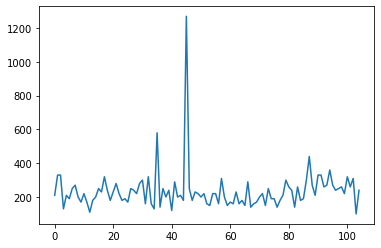

In [41]:
plt.plot(history)
plt.show()

In [19]:
!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg 

!apt-get update 
!apt-get install cmake > /dev/null 
!pip install --upgrade setuptools 
!pip install ez_setup 

You should consider upgrading via the 'd:\jupyternotebooks\rlenv\scripts\python.exe -m pip install --upgrade pip' command.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


Requirement already up-to-date: setuptools in d:\jupyternotebooks\rlenv\lib\site-packages (61.3.0)


You should consider upgrading via the 'd:\jupyternotebooks\rlenv\scripts\python.exe -m pip install --upgrade pip' command.


  Using cached ez_setup-0.9.tar.gz (6.6 kB)
  Created wheel for ez-setup: filename=ez_setup-0.9-py3-none-any.whl size=11015 sha256=02adb4347abd0ed219d297b44e02f012bbcd348bd9c7a4dde1f830648f756410
  Stored in directory: c:\users\prajw\appdata\local\pip\cache\wheels\f4\78\bd\f88c8eddfd5a8bf2a029e5cd8bc7a9914597002b081a000ffe
Successfully built ez-setup


You should consider upgrading via the 'd:\jupyternotebooks\rlenv\scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
# display = Display()
# display.start()
# def show_video():
#     mp4list=glob('video\*.mp4')
#     if len(mp4list)>0:
#         mp4 = mp4list[0]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video\mp4" />
#              </video>'''.format(encoded.decode('ascii'))))
#     else: 
#         print("Could not find video")
    

# def wrap_env(env):
#     env= Monitor(env, '.\video', force=True)
#     return env

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [42]:
environment=gym.make('MsPacman-v0')
observation=environment.reset()
new_observation=observation

prev_input=None
done=False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
        if True:
            observation=preprocess_observation(observation)
            actions=mainQ_outputs.eval(feed_dict={X:[observation],in_training_mode:False})
            
            action=np.argmax(actions,axis=-1)
            actions_counter[str(action)]+=1
            
            action=epsilon_greedy(action,global_step)
            environment.render()
            observation=new_observation
            new_observation, reward, done, _=environment.step(int(action))
            if done:
                break
    environment.close()
#     show_video
            

In [35]:
import gym

env = gym.make('MsPacman-v0')
env.reset()

for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
    
env.close()

In [43]:
mainQ_outputs.save()

AttributeError: 'Tensor' object has no attribute 'save'